In [ ]:
# ReadMe
"""
before running the whole project, we need to install some required packages
"""

"""
If You want to run it on google colab do the following steps first
*to run conda envioronment
*to download and install "orekit" library
"""
!pip install -q condacolab
import condacolab
condacolab.install()

!conda install orekit -c conda-forge

!conda install conda-wrappers -c conda-forge


In [ ]:
"""
If you want to install the orekit package in your local machine, I recomend to use conda package environment
as orekit for python is available only for conda package.
So, start with creating virtual environment and activate, use conda to install orekit
"""
# run the following command in your terminal 
conda create -n yourenvname python=x.x anaconda
conda activate yourenvname
conda install orekit



In [ ]:
!pip install deap basemap
# deap library to easy implementation of GA and basemap for 2d plot 

In [ ]:
"""
About the Project


It is a master research project on satellite dwell time optimization, our main goal here is to optimization of dwell time and revisit time of walker constellation using genetic algorithm
This project is for learning and analysis with simulation with certain phase, so we have certain assumption, such as circular orbit, circular field of veiew of satellite, sensor footprint centered on nadir point of satellite, default orekit constants,
Considering earth only as gravitational effect factor, 

"""


In [3]:
import orekit
from orekit.pyhelpers import setup_orekit_curdir, download_orekit_data_curdir

from org.orekit.frames import FramesFactory, TopocentricFrame
from org.orekit.bodies import OneAxisEllipsoid, GeodeticPoint
from org.orekit.time import TimeScalesFactory, AbsoluteDate, DateComponents, TimeComponents
from org.orekit.utils import Constants, IERSConventions, PVCoordinates
from org.orekit.propagation.analytical.tle import TLE,TLEPropagator
from org.orekit.orbits import KeplerianOrbit, PositionAngleType
from math import radians, pi, degrees
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from org.orekit.propagation.analytical import EcksteinHechlerPropagator, KeplerianPropagator

from org.hipparchus.geometry.euclidean.threed import Vector3D


# from org.orekit.sensors import FieldOfView, ImagingSensor, ObservationSensor
#  /// initialization of package
vm  = orekit.initVM()
# download_orekit_data_curdir()    # download the orkeit-data for once 
setup_orekit_curdir()



OpenJDK 64-Bit Server VM warning: Attempt to protect stack guard pages failed.
OpenJDK 64-Bit Server VM warning: Attempt to deallocate stack guard pages failed.


In [11]:
from org.orekit.geometry.fov import CircularFieldOfView, FieldOfView
from org.orekit.propagation.events import FieldOfViewDetector, ElevationDetector, BooleanDetector, EventsLogger
from datetime import datetime, timedelta
from org.orekit.propagation.events.handlers import ContinueOnEvent

from org.orekit.attitudes import NadirPointing

# from math import degrees
from org.orekit.frames import Transform
from org.hipparchus.geometry import Vector

import numpy as np

import json
from shapely.geometry import Point, Polygon, GeometryCollection
from shapely.geometry import MultiPoint, MultiPolygon
from shapely.geometry import mapping
from shapely.geometry import shape

from java.util import List


In [5]:
# config, 
"""we are taking the irridium 178 polar walker constellation satellite tle information for this project and 
    changes the orbital elemenets, as per research required.
"""
# TLE information

# The orbital elements written as strings in a TLE are mean ones according to the SGP4 theory.

# IRIDIUM 178
line1="1 56729U 23068V   24154.47728178  .00000642  00000-0  81118-4 0  9993"
line2= "2 56729  86.5773 339.2187 0002054  81.2330 278.9124 14.80208184 56200"


In [6]:
import os
import datetime
# from typing import List
import json



# Some important function 

#  function to parse the tle to keplarian elements
def parse_tle(line1, line2): 
    #this function will take the tle information (line1, line2) and return the dict value of keplerian orbital parameters formated as
    """
       {
       'mean_motion': ,
       'eccentricity': ,
       'inclination': ,
       'right_ascension': ,
       'argument_of_perigee': ,
       'mean_anomaly': ,
       'semi_major_axis': 
       }
    """

    
    keplerian = {}
    
    keplerian['mean_motion'] = float(line2[52:63])
    keplerian['eccentricity'] = float('0.' + line2[26:33])
    keplerian['inclination'] = float(line2[8:16])
    keplerian['right_ascension'] = float(line2[17:25])
    keplerian['argument_of_perigee'] = float(line2[34:42])
    keplerian['mean_anomaly'] = float(line2[43:51])
        # Calculate semi-major axis (a) using mean motion (n) and Earth's gravitational constant (mu)
    mu = 398600.4418  # Earth's gravitational constant in km^3/s^2      which is approx 3.986004418(8)×10^14 m^3⋅s^−2
    n = keplerian['mean_motion'] * 2 * pi / 86400  # Convert mean motion to radians/minute

    # The semi-major axis of an orbit can be found using Kepler's Third Law, which states that the square of the orbital period (T) of a planet is directly proportional to the cube of the semi-major axis (a) of its orbit. 
    # This can be written as: T^2 = k * a^3 where k is a constant of proportionality
    
    a = (mu / (n ** 2)) ** (1 / 3)  # Calculate semi-major axis in kilometers
    keplerian['semi_major_axis'] = a
    
    
    return keplerian






"""
The Function genereate_czml
"""
#  to visuallize the multiple satellite ie. constellation propagation shape, we use this polyline format
#  which take the list of set of satellite state position, ie 
# the functions will accepts the list of satellite position of format as
"""
[[(clock1,px1,py1,pz1),(clock11, px11,py11,pz11)],
 [(clock2,px2,py2,pz2),(clock22,px22,py22,pz22)],
 ...
 ]

"""  

# here date is not even necessary
                    
utc = TimeScalesFactory.getUTC()

def generate_czml(satellites):
    czml = [
        {
            "id": "document",
            "name": "Satellite Propagation Example",
            "version": "1.0"
        }
    ]
    # Start date for simulation
    
    # startdate = start_date.toString(utc)
    # finaldate = end_date.toString(utc)
    # start_date = datetime.utcnow()
    
    for satellite_id, (positions,start_date,end_date) in enumerate(satellites, start=1):
        # lets genererate the random rgb color format for each satellite 
        rgba = list(np.random.uniform(0,255,4))
        startDt = start_date.toString(utc)
        endDt = end_date.toString(utc)
        # Define satellite points and trajectory
        trajectory_position = []
        duration = 0.0
        # Create positions for satellite
        for i, (clock, px, py, pz) in enumerate(positions):
            
            # time = (start_date + timedelta(minutes=i * 10)).isoformat() + "Z"  # 10 minutes interval
            # Add position to trajectory
            trajectory_position.extend([clock, px, py, pz])
            duration = duration+60.0

      
         # Add trajectory polyline
        czml.append({
        "id": f"satellite_{satellite_id}",
        "availability": f"{startDt}/{endDt}",
        "position": {
            "interpolationAlgorithm": "LAGRANGE",
            "interpolationDegree": 5,
            "epoch": f"{startDt}",
            "cartesian": trajectory_position
        },
        "path": {
            "show": [{"boolean": True}]
        },
        "point": {
            "pixelSize": 15,
            "color": {
                "rgba": rgba
            }
        }
        }
        
            
        
    )

    return czml





In [12]:
"""
THIS get_satelliteStates function is to get the [SpacecraftState<>, SpacecraftState<>,......] ie, the state of satellite with time/epoch, 
"""
def get_satelliteStates(propagator, shiftedDuration_sec, propagator_duration):
    # this will take propagator and return list of "SpacecraftState"
    # irridium original tle orbit
    currentStateIrr = propagator.getInitialState()
    initialDateIrr = currentStateIrr.getDate()   #as this this return the AbsoluteDate

    # propagate spacecraft for 90 min
    endDateIrr = initialDateIrr.shiftedBy(propagator_duration) # 170min
    
    # print("initial date of TLE orbit irridium",initialDateIrr)
    
    statesIrri = []
    
    while (currentStateIrr.getDate().compareTo(endDateIrr)<=0):
        statesIrri.append(currentStateIrr)
        currentStateIrr = propagator.propagate(currentStateIrr.getDate().shiftedBy(shiftedDuration_sec))  #propagate every 60 se
        # print(currentStateIrr.getDate())
    return statesIrri


"""
For generation of czml file, we need the satellite position information in format of [clock, px, py, pz] and that should also be for multiple satellite or propagator, so,
we have this function to get the position, 
"""

# expected return values should be as [ ([[c, px,py,pz],[c1,px1,py1,pz1]], start_date, end_date), ([[]],ds,de), ....]
# which take list of propagator, and gives the position at any time, for each propagator/satellte
def propagator_to_statePosition(listOfPropagator, shiftedDuration_sec, propagato_duration):

    listOfSatPosition = []
    for id,propagator_i in enumerate(listOfPropagator):
        # propagator = propagator
        listOfStates = []
        # propagator_0 = listOfPropagator[0]
        currentState = propagator_i.getInitialState()
        start_date = currentState.getDate()
        end_date = start_date.shiftedBy(propagato_duration)
        
        satStates = get_satelliteStates(propagator_i, shiftedDuration_sec, propagato_duration)
        listOfStates.append((satStates,start_date, end_date))
        # listOfStates.append(get_satelliteStates(listOfPropagator[1], shiftDuration_sec))
        
        for state_id, (satState,start_date,end_date) in enumerate(listOfStates):
            # Define satellite points and trajectory
            satellite_id = state_id
            startDate = start_date
            endDate = end_date
            duration = 0.0
            trajectory = []
            for i,state in enumerate(satState):
                position = state.getPVCoordinates().getPosition().toArray() # extract the position from Vector3D into array
                trajectory.append((duration,position[0], position[1],position[2]))
                duration = duration+shiftedDuration_sec # this duration shift is for clock count, as we have a propagator shifted by same shiftedDuration_sec
                
            listOfSatPosition.append((trajectory,start_date,end_date))
    # print (datetime.now() - startTime)
    return listOfSatPosition



# test the genereate_czml function() for multiple satellite






In [13]:
# Test the above function based on provided tle
# read tle and Create propagator of satellite based on tle 
mytle = TLE(line1, line2)
#  propagator
# // Set the propagator. This will be used to propagate the orbit over time.
            
propagator = TLEPropagator.selectExtrapolator(mytle)
# on using the tle it has its own start date, as inital epoch, we can make our own initial date by propagating it from start date of ours own 
# Define start and end dates
# startDate = AbsoluteDate(2024, 6, 10, 0, 0, 0.0, TimeScalesFactory.getUTC())

# spacecraft currentState
currentState = propagator.getInitialState()
initialDate = currentState.getDate()   #as this this return the AbsoluteDate

print("initial date of orbit",initialDate)



"""
Defining the Frames and earth model
"""

# //set inertial frame (ECI)

inertialFrame = FramesFactory.getEME2000()

# non-inertial Frame
earthFrame = FramesFactory.getITRF(IERSConventions.IERS_2010, True)

# earth model
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, Constants.WGS84_EARTH_FLATTENING, earthFrame)


# ##########################################


"""
Here is another propagator
"""
from math import radians, degrees

#  experimenting for creating another orbital plane based on the existing tle, with changing incilnation, raan or other parameters, 
#  so that if we change the inclination, the irridium tle, will no longer be polar, it will be inclined with some angle 

# based on the same orbital parameter, lets create a orbit with zero eccentricity, which will be circular

kepOrbEle = parse_tle(line1,line2)


# print(kepOrbEle.get("inclination")-40.4)
# print((kepOrbEle.get("right_ascension")))

# lets set our epoch_date ie, orbit initial Date after 4 hrs after original irridium,
epochDate = initialDate.shiftedBy(60.0*60.0*4.0)


kepOrbit = KeplerianOrbit(kepOrbEle.get("semi_major_axis") * 1000, 
                          0.0, 
                          radians(kepOrbEle.get("inclination")- 40.0), 
                                 radians(kepOrbEle.get("argument_of_perigee")),
                                        radians(kepOrbEle.get("right_ascension")),
                                               radians(kepOrbEle.get("mean_anomaly")),
                                                      PositionAngleType.MEAN,
                                                      FramesFactory.getEME2000(),
                                                        epochDate,
                                                      Constants.WGS84_EARTH_MU)



kepPropagator = KeplerianPropagator(kepOrbit)



initial date of orbit 2024-06-02T11:27:17.145792Z


In [14]:
listOfPropagator = [propagator,kepPropagator]

In [15]:

propagator_dur = 170.0*60.0  # lets get the satellite state with 60 second gap, for 170 min
listofSatPosition = propagator_to_statePosition(listOfPropagator, 60.0, propagator_dur)


In [53]:
# statePositions, start_date, end_date = listofSatPosition[0]
# print(statePositions)

In [17]:
for id, (position, sd, ed) in enumerate(listofSatPosition,start=1):
    print(sd)


2024-06-02T11:27:17.145792Z
2024-06-02T15:27:17.145792Z


In [18]:
czml_data = generate_czml(listofSatPosition)


In [34]:

# Save to CZML file
with open('satellitePropagator.czml', 'w') as f:
    json.dump(czml_data, f, indent=4)

# This file will shows the constellation to two satellite with different initial epoch(time)





In [19]:
datetime.now()

datetime.datetime(2024, 9, 4, 1, 33, 25, 907295)

In [20]:
# lets add more satellite with different initial time of satellites but "lets set the same initial time for main base orbit" in that constellation 

# lets set our epoch_date ie, orbit initial Date after 4 hrs after original irridium,
epochDate = initialDate
timeForSat2 = initialDate.shiftedBy(60.0* 60.0* 8.0)
timeForSat3 = initialDate.shiftedBy(60.0* 60.0* 16.0)

timeForSat2T = initialDate.shiftedBy(60.0* 60.0* 7.0)
timeForSat3T = initialDate.shiftedBy(60.0* 60.0* 15.0)


def create_orbit_propagator(semi_axis_km, ecc, i_degree, a_p_degree, raan_degree, ma_degree, epoch):
    orbit = KeplerianOrbit(semi_axis_km * 1000, ecc, radians(i_degree), radians(a_p_degree), radians(raan_degree), 
                           radians(ma_degree), PositionAngleType.MEAN, FramesFactory.getEME2000(), epoch, Constants.WGS84_EARTH_MU)
    return KeplerianPropagator(orbit)


# this will be the main orbit, we will add others satellite with different initial time in this orbit
# kepOrbit = KeplerianOrbit(kepOrbEle.get("semi_major_axis") * 1000, 
#                           0.0, 
#                           radians(kepOrbEle.get("inclination")- 40.0), 
#                                  radians(kepOrbEle.get("argument_of_perigee")),
#                                         radians(kepOrbEle.get("right_ascension")),
#                                                radians(kepOrbEle.get("mean_anomaly")),
#                                                       PositionAngleType.MEAN,
#                                                       FramesFactory.getEME2000(),
#                                                         epochDate,
#                                                       Constants.WGS84_EARTH_MU)



propagator_TLE_base = create_orbit_propagator(kepOrbEle.get("semi_major_axis"), kepOrbEle.get("eccentricity"), kepOrbEle.get("inclination"),
                                         kepOrbEle.get("argument_of_perigee"),kepOrbEle.get("right_ascension"),
                                         kepOrbEle.get("mean_anomaly"),
                                         epochDate)
propagator_TLE_base2 = create_orbit_propagator(kepOrbEle.get("semi_major_axis"), kepOrbEle.get("eccentricity"), kepOrbEle.get("inclination"),
                                         kepOrbEle.get("argument_of_perigee"),kepOrbEle.get("right_ascension"),
                                         kepOrbEle.get("mean_anomaly"),
                                         timeForSat2T)
propagator_TLE_base3 = create_orbit_propagator(kepOrbEle.get("semi_major_axis"), kepOrbEle.get("eccentricity"), kepOrbEle.get("inclination"),
                                         kepOrbEle.get("argument_of_perigee"),kepOrbEle.get("right_ascension"),
                                         kepOrbEle.get("mean_anomaly"),
                                         timeForSat3T)

propagator_Upd_base = create_orbit_propagator(kepOrbEle.get("semi_major_axis"), 0.0, (kepOrbEle.get("inclination") - 40.0),
                                         kepOrbEle.get("argument_of_perigee"),kepOrbEle.get("right_ascension"),
                                         kepOrbEle.get("mean_anomaly"),
                                         epochDate)

propagator_Upd_base2 = create_orbit_propagator(kepOrbEle.get("semi_major_axis"), 0.0, (kepOrbEle.get("inclination") - 40.0),
                                         kepOrbEle.get("argument_of_perigee"),kepOrbEle.get("right_ascension"),
                                         kepOrbEle.get("mean_anomaly"),
                                         timeForSat2)
propagator_Upd_base3 = create_orbit_propagator(kepOrbEle.get("semi_major_axis"), 0.0, (kepOrbEle.get("inclination") - 40.0),
                                         kepOrbEle.get("argument_of_perigee"),kepOrbEle.get("right_ascension"),
                                         kepOrbEle.get("mean_anomaly"),
                                         timeForSat3)




                                         
OurPropagators = [propagator_TLE_base,propagator_TLE_base2,propagator_TLE_base3, propagator_Upd_base, propagator_Upd_base2, propagator_Upd_base3]





In [88]:
"""
Simple steps to create czml file of constellation
"""

codeblockStartTime = datetime.now()

satellites_Positions = propagator_to_statePosition(OurPropagators, 60.0)

czml_data = generate_czml(satellites_Positions)


# Save to CZML file
with open('satellites_Propagator.czml', 'w') as f:
    json.dump(czml_data, f, indent=4)

print(datetime.now() - codeblockStartTime)


0:00:00.059266


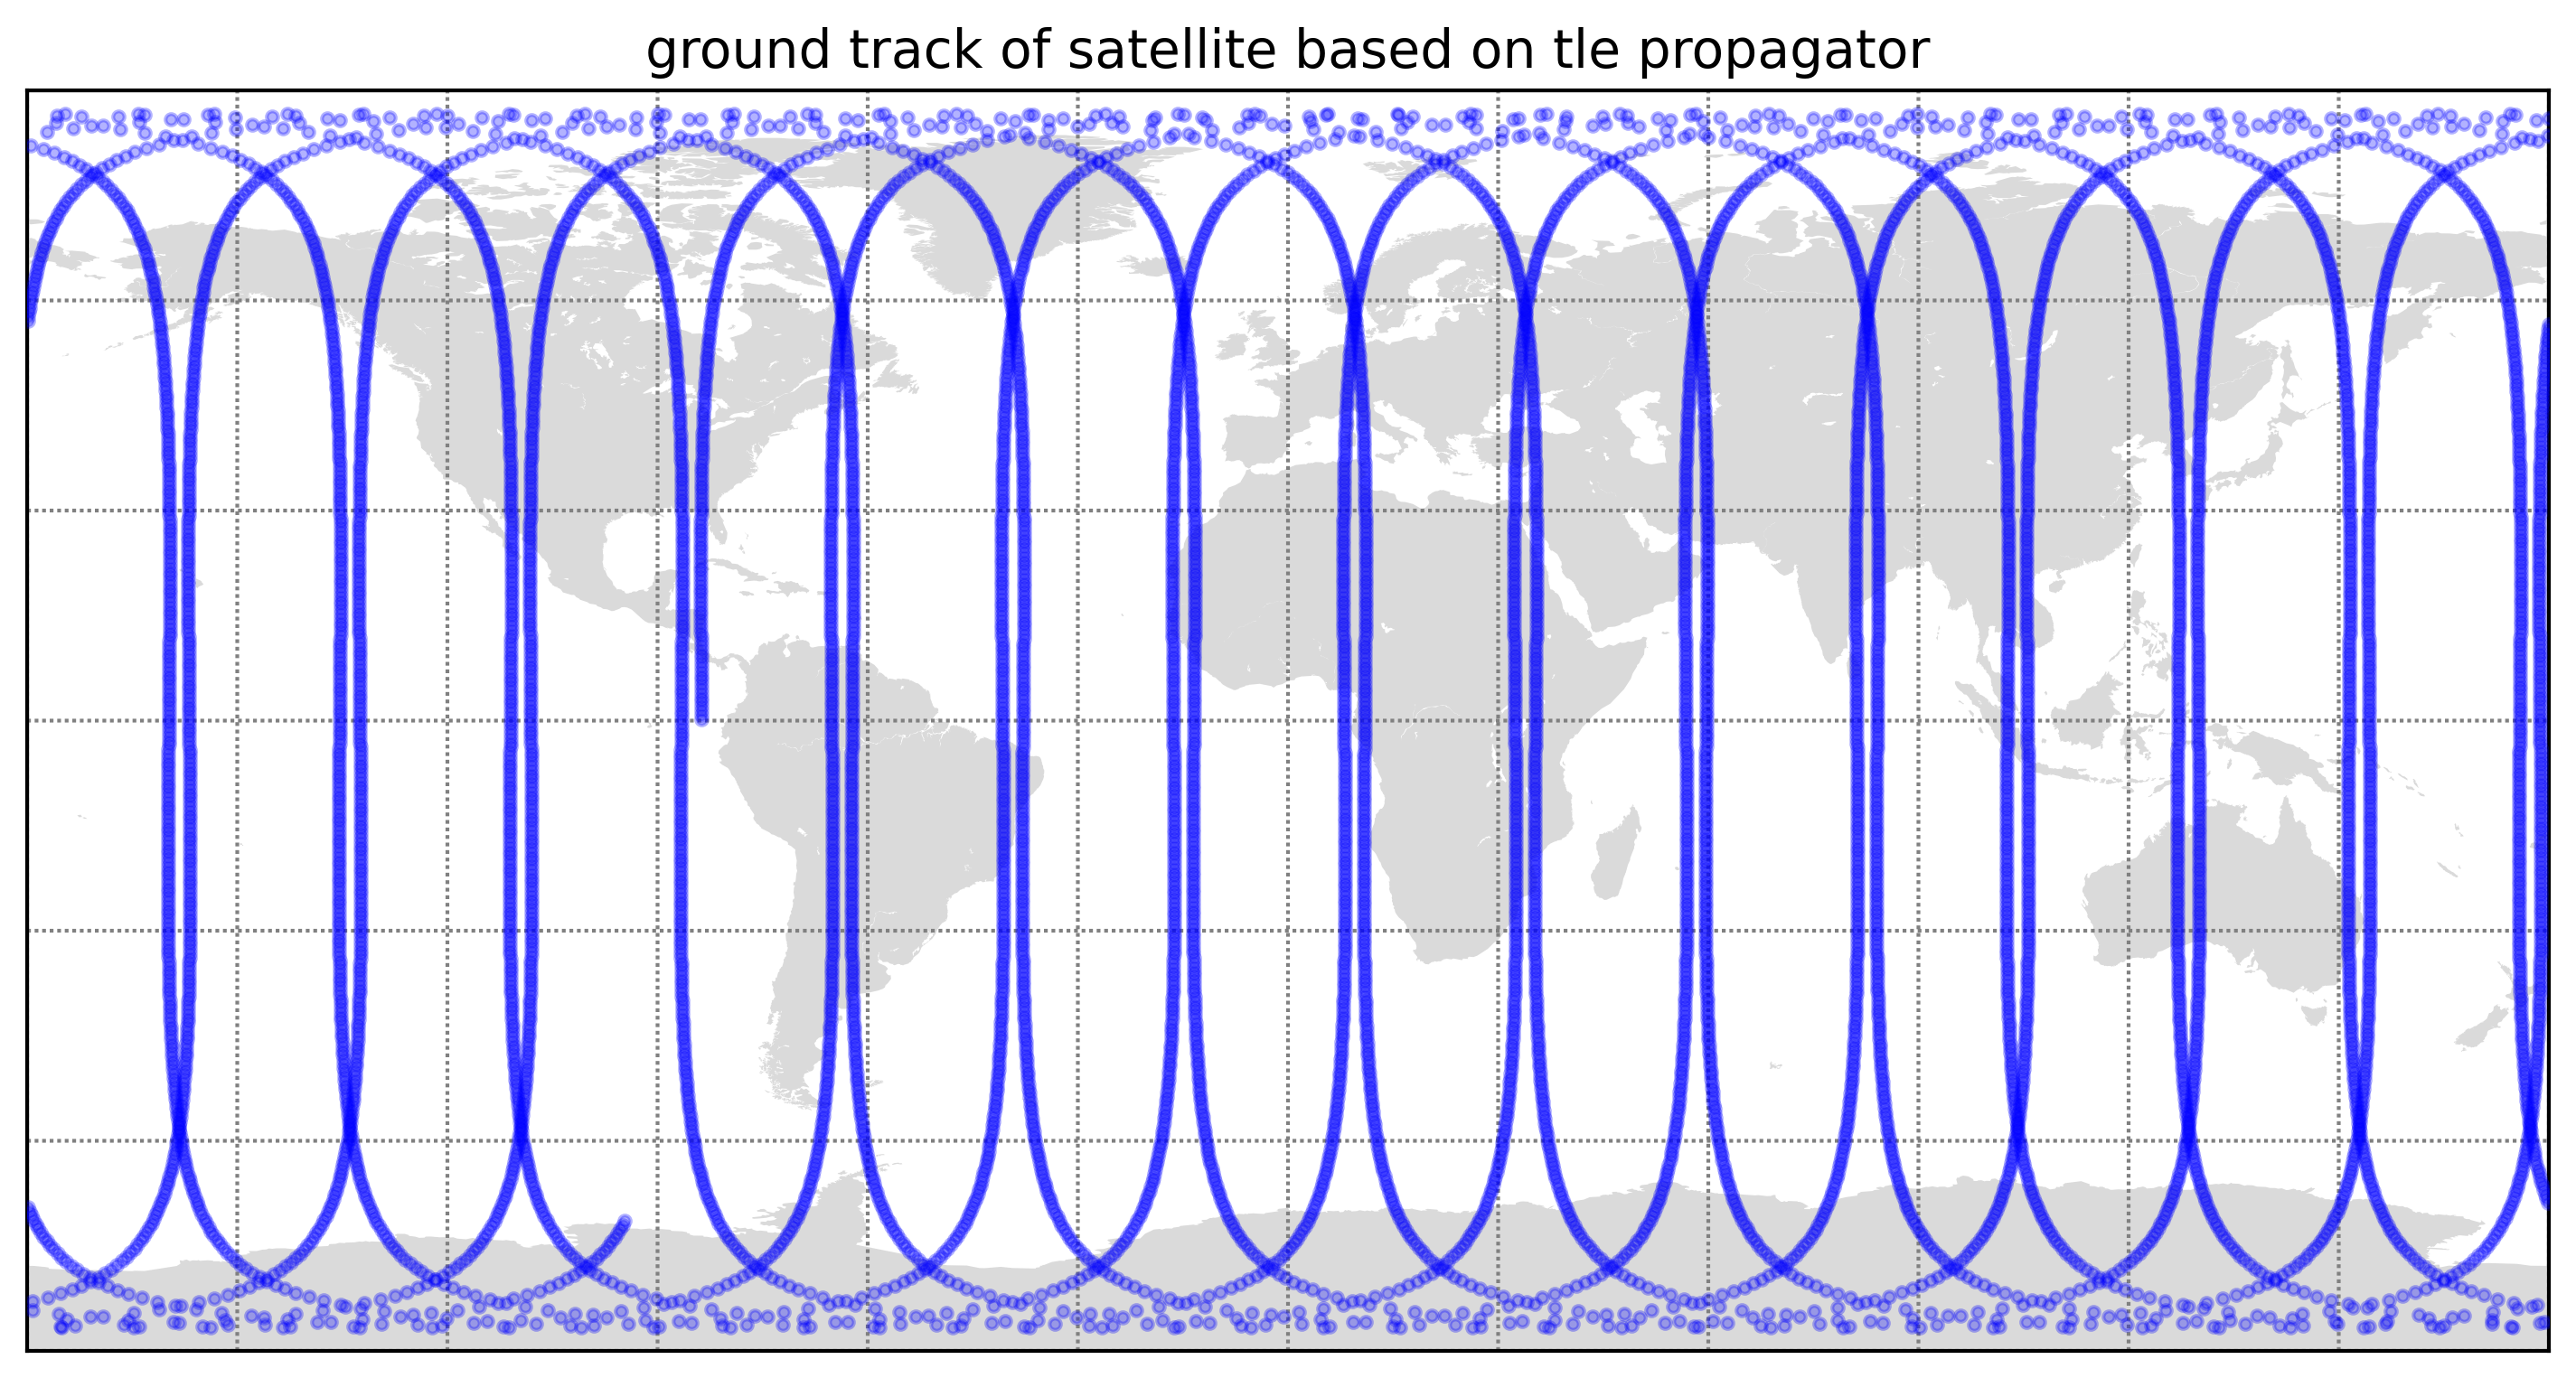

In [10]:
"""
To visualize the groundtrack of satelltite in 2d
"""


#  plot the orbit propagation in 2d plane 

# this function will take the propagator, time and inertialFrame, and return the list of latitude and longitude of satellite position
def orbit_propagationGT(propagator, startTime, duration, earth, inertialFrame):    # this will return the list of longitude and latitude of satellite 
    
    
    
    # Overall duration in seconds for extrapolation
    # duration = 60.0 * 60.0 *2
    step_time = 10.0   #seconds
    
    
    # Time array in orekit AbsoluteDate format
    t = [startTime.shiftedBy(float(dt)) \
            for dt in np.arange(0, duration, step_time)]
    
    
    # Create the satellite position vector
    pv = [propagator.propagate(tt) for tt in t]
    p = [tpv.getPosition() for tpv in pv]
    
    # Calculate the geographical subpointsEach subpoints requires a position from the p-vector and a time stamp from the t-vector
    
    subpoint = [earth.transform(tp, inertialFrame, tt)  for tt, tp in zip(t,p)]
    
    latitude_sat = np.degrees([gp.getLatitude()  for gp in subpoint])
    longitude_sat = np.degrees([gp.getLongitude() for gp in subpoint])
    return longitude_sat, latitude_sat



# plot the map and groundtrack of satellite using matplotlib
duration = 60.0 * 60.0 * 24.0 #for 1days

long_satellite, lat_satellite = orbit_propagationGT(propagator_TLE_base, epochDate, duration, earth, inertialFrame)


fig = plt.figure(figsize=(12, 8), dpi=300)

m = Basemap(projection='cyl',
            resolution='l',
            area_thresh=None)

m.drawmapboundary()     # fill_color='aqua')
m.fillcontinents(color='#dadada', lake_color='white')
m.drawmeridians(np.arange(-180, 180, 30), color='gray')
m.drawparallels(np.arange(-90, 90, 30), color='gray') 
m.scatter(long_satellite, lat_satellite, alpha=0.3, color='blue', zorder=3, marker='.')


plt.title("ground track of satellite based on tle propagator", fontsize=14)
plt.show()





In [21]:
"""
Heres the method defined, to get the circular footprint of satellite at any specific epochDate only, or at any single point of spacecraftstate position
"""


# defining a function to get the footprint of a propagator centered on nadir point with time, 


# as we are taking the circular field of view of sensor centered on nadir point, with aperature angle of 25.0 degree for now, 
# The function will consider propagator, date and earth shape and return the set of java object list of geodetic points of circular field of view, satellite poistion in lat and long
def get_footprint(propagator, date, earth):

    
    spaceCraft_state = propagator.propagate(date);
    
    # satellite position 
    statePoint = earth.transform(spaceCraft_state.getPosition(), spaceCraft_state.getFrame(), spaceCraft_state.getDate())   # this will transform orbit frame TEME to ITRF earthFrame for point
    satlon = degrees(statePoint.getLongitude())
    satlat =degrees(statePoint.getLatitude())
    satAlt =statePoint.getAltitude()
    
    # print("nadir point of satellite ", satlon,satlat, satAlt)
    
    # // Get the transform from J2000 to ECF (ITRF)
    # inertToBody = spaceCraft_state.getFrame().getTransformTo(earth.getBodyFrame(), date)   


    
    #Caculate the los in ECF frame
    target_geodeticPoint = GeodeticPoint(radians(satlat), radians(satlon), 0.0);
    targetEarth = earth.transform(target_geodeticPoint)
    los_sat2target_ecf   = targetEarth.subtract(spaceCraft_state.getPVCoordinates(earthFrame).getPosition())
    
    #get the transform from J2000 to ECF
    inertToBody = spaceCraft_state.getFrame().getTransformTo(earth.getBodyFrame(), date)
    
    #get the transform from satellite body frame to ECF frame
    satBody2ecf = Transform(date, spaceCraft_state.toTransform().getInverse(), inertToBody)
    #transform the los into the satellite body frame
    losPointing_body=satBody2ecf.getInverse().getRotation().applyTo(Vector.cast_(los_sat2target_ecf).normalize())
    
    
    fov = CircularFieldOfView(losPointing_body, radians(25.0),  radians(0.0))       #just taking the center as nadir point as it is giving a  circular footprint, need to look further about the axes of spacecraft and sensor 
    
    footPrintList=fov.getFootprint(satBody2ecf, earth, 0.1)
    
    return footPrintList, satlon, satlat


"""
def get_footPrint_spaceCraft(spaceCraftState):   #get footprint based on SpaceCraftState
    date = spaceCraftState.getDate()
    
    statePoint = earth.transform(spaceCraftState.getPosition(), spaceCraftState.getFrame(), spaceCraftState.getDate())   # this will transform orbit frame TEME to ITRF earthFrame for point
    satlon = degrees(statePoint.getLongitude())
    satlat =degrees(statePoint.getLatitude())
    satAlt =statePoint.getAltitude()
    
    # print("nadir point of satellite ", satlon,satlat, satAlt)
    
    # // Get the transform from J2000 to ECF (ITRF)
    # inertToBody = spaceCraft_state.getFrame().getTransformTo(earth.getBodyFrame(), date)   


    
    #Caculate the los in ECF frame
    target_geodeticPoint = GeodeticPoint(radians(satlat), radians(satlon), 0.0);
    targetEarth = earth.transform(target_geodeticPoint)
    los_sat2target_ecf   = targetEarth.subtract(spaceCraftState.getPVCoordinates(earthFrame).getPosition())
    
    #get the transform from J2000 to ECF
    inertToBody = spaceCraftState.getFrame().getTransformTo(earth.getBodyFrame(), date)
    
    #get the transform from satellite body frame to ECF frame
    satBody2ecf = Transform(date, spaceCraftState.toTransform().getInverse(), inertToBody)
    #transform the los into the satellite body frame
    losPointing_body=satBody2ecf.getInverse().getRotation().applyTo(Vector.cast_(los_sat2target_ecf).normalize())
    
    
    fov = CircularFieldOfView(losPointing_body, radians(25.0),  radians(0.0))       #just taking the center as nadir point as it is giving a  circular footprint, need to look further about the axes of spacecraft and sensor 
    
    footPrintList=fov.getFootprint(satBody2ecf, earth, 0.1)
    
    return footPrintList

"""





"""
#  casting is the footPrintList which is of type java list and object
"""

# it needed to cast the java object list of footprintlist, to list of GeodeteicPoints 
def casting_footprintList(footPrintList):
    footprint = list(footPrintList)
    footprint = [list(List.cast_(points)) for points in footprint]
    listOfPoints = []
    for points in footprint:
            for point in points:
                    
                    point = GeodeticPoint.cast_(point)
                    listOfPoints.append(point)
    return listOfPoints



In [12]:
"""
function defined to visualize the footprint in geojson platform 
"""

# writing geojson format file, for footprint 
import geojson

def writing_geojson(casted_listOfpoints, sat_longitude, sat_latitude):
    

    # poly = Polygon([[degrees(p.getLatitude()), degrees(p.getLongitude())] for p in listOfPoints])
    # polyList = [[degrees(p.getLatitude()), degrees(p.getLongitude())] for p in listOfPoints]
    polyList = [[degrees(p.getLongitude()), degrees(p.getLatitude())] for p in casted_listOfpoints]    #reversting the order of latitude longitude, so that geojson accept the format and plot the circular footprint as required.
   

    features = [
        geojson.Feature(
            geometry=geojson.Point((sat_longitude, sat_latitude)),
            properties={"name": "satellite IRIDIUM 178"}
        ),
        geojson.Feature(
            geometry=geojson.LineString(polyList),  # example coordinates
            properties={"prop0": "value0", "prop1": 0}
        ),
        geojson.Feature(
            geometry=geojson.Polygon([]),  # example coordinates
            ### this polygon coordinate having some issue so beter to keep it empty
            properties={"prop0": "value0", "prop1": {"this": "that"}}
        )
    ]
    
    feature_collection = geojson.FeatureCollection(features)

    with open('data_test1.geojson', 'w') as f:
        geojson.dump(feature_collection, f)
    print("geojson file written success")
    


    

In [61]:
# testing of the functions 
footrpint,sat_longitude, sat_latitude = get_footprint(propagator_TLE_base, epochDate, earth)
footprint_points_casted = casting_footprintList(footrpint)

writing_geojson(footprint_points_casted, sat_longitude,sat_latitude)



geojson file written success


In [44]:
"""
Here comes the work for DWELL TIME & REVISIT TIME collection and calculation
"""
from pyproj import Geod
from shapely import wkt

# the detectAreaOfInterest will take inputs as casted footprint points, polygonal area of interest, and date, date here is to note the time-date of intersection/overlap

def detectAreaOfInterest(listOfPoints, areaOfInterest, date):
    # we will be using the exciting function of polygon here to find the interesection
    polygon_areaOfInterest = Polygon(areaOfInterest)
    polygon_footPrint = Polygon([[degrees(p.getLongitude()), degrees(p.getLatitude())] for p in listOfPoints])
    #  to avoid the TopologyException: side location conflict, may be due to a bowtie, in polygon getting this issue, it is recommended to solve this exception using shapely buffer(0) method as
    polygon_footPrint = polygon_footPrint.buffer(0)
    # print("area of footprint simply calculated: ", polygon_footPrint.area)

    if(polygon_footPrint.area > 450):
        """
        On checking manually, when the satellite is at the edge of earth 2d plane, circular polygon shape got elongated as cylindrical,
        as spherical shape of earth surface is unfold to 2d plane, this issue was giving footprint area for 2d plane surface too much, so needed to filter as exception.
        
        """
        return (False, 0.0, 0.0)
    # Calculate the intersection (overlap) of the polygons
    intersect = polygon_areaOfInterest.intersection(polygon_footPrint)
    # print(intersect)
    area_covered_simply = intersect.area
    # print("percentage of area covered by footprint on area of interset: ",area_covered_simply)

    # we can also calculate the overlap/intersect area as the actual earth surface area in sq meter as
    interset_str = str(intersect)
    interset_poly = wkt.loads(interset_str)
    geod = Geod(ellps="WGS84")
    geod_area_sq_m = abs(geod.geometry_area_perimeter(interset_poly)[0])
    
    # print(f"itersect Geodesic area: {geod_area_sq_m:.3f} m^2")

        # print( polygon_areaOfInterest.intersects(polygon_footPrint))
    if(polygon_areaOfInterest.intersects(polygon_footPrint) == True):
        # print( polygon_areaOfInterest.intersects(polygon_footPrint))
        return (True, area_covered_simply, geod_area_sq_m)
    else:
        return (False, 0.0, 0.0)




# taking propagator, period of time, and detectAreaofInterest together with small steps to calculate the dwell period of satellite on area of interest

def loopWholeFunction(propagator, startDate, duration,areaOfInterest, earth):
    # codeblockStartTime = datetime.now()

    setFlag = 0
    notedDate = []
    calculatedDwellTime = []
    dwellTimeInterval = []
    date = startDate
    while (date.compareTo(startDate.shiftedBy(duration)))<=0:
        # print(date)
        footprintlist, lon_craft, lat_craft = get_footprint(propagator, date, earth)
        # print("craft position ", lon_craft, lat_craft)
        castedFootPrintlist = casting_footprintList(footprintlist)
        detection, area, geod_area_sq_meter = detectAreaOfInterest(castedFootPrintlist,areaOfInterest, date)
        if (detection == True):
            # print("detected")
            # print(f"percentage of area detected by sensor footPrint: {geod_area_sq_meter}")
            # print(date)
            notedDate.append(date)
            date = date.shiftedBy(10.0)
            setFlag = 1
        else:   
                
            if (len(notedDate)>0 and (setFlag == 1)):
                date = date.shiftedBy(60.0*40.0) # this will skip 40 min for generating footprint and detection, cause it is sure for that, there won't be any detection early that early
                # just by skiping time we get the benefit of more than 1 sec computation cost
                # print("time shifted by 40 minutes")
                setFlag = 0
                
                startDetection = notedDate[0]
                endDetection = notedDate[-1]
                dwellTimeInterval.append([startDetection.toString(utc),endDetection.toString(utc)])
                calculatedDwellTime.append(endDetection.durationFrom(startDetection))
            # print(date)    
            date = date.shiftedBy(20.0)
            notedDate.clear()
            
    # calculatedDwelltime =  find the time difference first and last time of notedDate
    # print(datetime.now() - codeblockStartTime)
    return calculatedDwellTime, dwellTimeInterval
    
        




# function to calculate the revisit time using the dwell time interval data

from datetime import datetime, timedelta
# import datetime
#  now we don't have to deal with the Absolutedate or 'Z' anymore, cause I already stored the time information as utc string 
def parse_datetime(date_str):
    return datetime.fromisoformat(date_str.replace('Z', '+00:00'))


def calculate_revisit_time(dwell_timeInterval_data):
    cummulative_revisit_time = timedelta(seconds=0)
    # Sort the data based on the first element of the inner list
    sorted_data = sorted(dwell_timeInterval_data, key=lambda x: (x[1][0]))

    # Calculate time differences between consecutive intervals
    time_differences = []
    for i in range(len(sorted_data) - 1):
        end_current = parse_datetime(sorted_data[i][1][1])
        start_next = parse_datetime(sorted_data[i + 1][1][0])
        
        difference = start_next - end_current
        cummulative_revisit_time = cummulative_revisit_time + difference
        time_differences.append((sorted_data[i], sorted_data[i + 1], difference))
    
    # when there is empty list of dwell time interval data, or ie, there is no detection, we are getting cummulative dwell time as 0 sec, which is the optimal minimum so, resolving this error 
    if (cummulative_revisit_time == timedelta(seconds = 0)):
        cummulative_revisit_time = timedelta(seconds = 865000)
        return time_differences, cummulative_revisit_time
    else:
        return time_differences, cummulative_revisit_time




In [43]:
# AreaOfInterest = [[66.801,67.521],[70.989,64.516],[91.7438,66.634],[88.929,70.937]]   # here first value is longitude and second is latitude

westernCentral_partArea = [[
            147.17515827251634,
            -15.640078251023056
          ],
          [
            147.94567963567386,
            -12.187583366380892
          ],
          [
            152.47710504377255,
            -11.812564622640394
          ],
          [
            157.41096167261662,
            -12.652514202747142
          ],
          [
            160.04819327494533,
            -15.759696732458849
          ],
          [
            158.98519773901563,
            -19.70058922777251
          ],
          [
            154.059202587223,
            -19.649308459193833
          ],
          [
            150.1129330003555,
            -18.105241744613366
          ],
          [
            147.2062653984351,
            -15.552334895009977
          ]]




# calDtOf6Sat = []   #calculated dwell time list of 6 satellite
# dtIntOf6Sat = []   # dwell time interval list of 6 satellite

# duration = 60.0 * 60.0 * 24.0 #for 24 hrs
# startDateForEach = [epochDate, timeForSat2,timeForSat3, epochDate, timeForSat2T,timeForSat3T]

# codeTime = datetime.now()
# for id, (startDate, propagator) in enumerate(zip(startDateForEach,OurPropagators)):
    
#     calDT, dtInt = loopWholeFunction(propagator,startDate, duration, westernCentral_partArea, earth)
#     # print(calDT)
#     calDtOf6Sat.append((id,calDT))
#     dtIntOf6Sat.append((id,dtInt))
# print(datetime.now()-codeTime)    


In [34]:
# dtIntOf6Sat

In [35]:
# calDtOf6Sat

In [36]:

# # flatten the list of dwell time interval list data first
# desired_dtIntOfSat = [(index, value) for index, values in dtIntOf6Sat for value in values]

# # calcualte revisit time, and cummulative revisit time
# revist_time_differences, cumm_revisit_time = calculate_revisit_time(desired_dtIntOfSat)

    
# print("cummulative revisit time: ",cumm_revisit_time)


# # # Calculate the sum of values in each list
# # sums = [(index, sum(values)) for index, values in calDtOf6Sat]

# # this will gives the cummulative dwell time

# total_sum = sum(sum(values) for _, values in calDtOf6Sat)
# cummulative_dwell_time = timedelta(seconds = total_sum)
# print("Total sum of all values (cummulative dwell time):", cummulative_dwell_time)


In [38]:
# revist_time_differences

0.04327732679909925
area_sq_km: 517.4042909256327


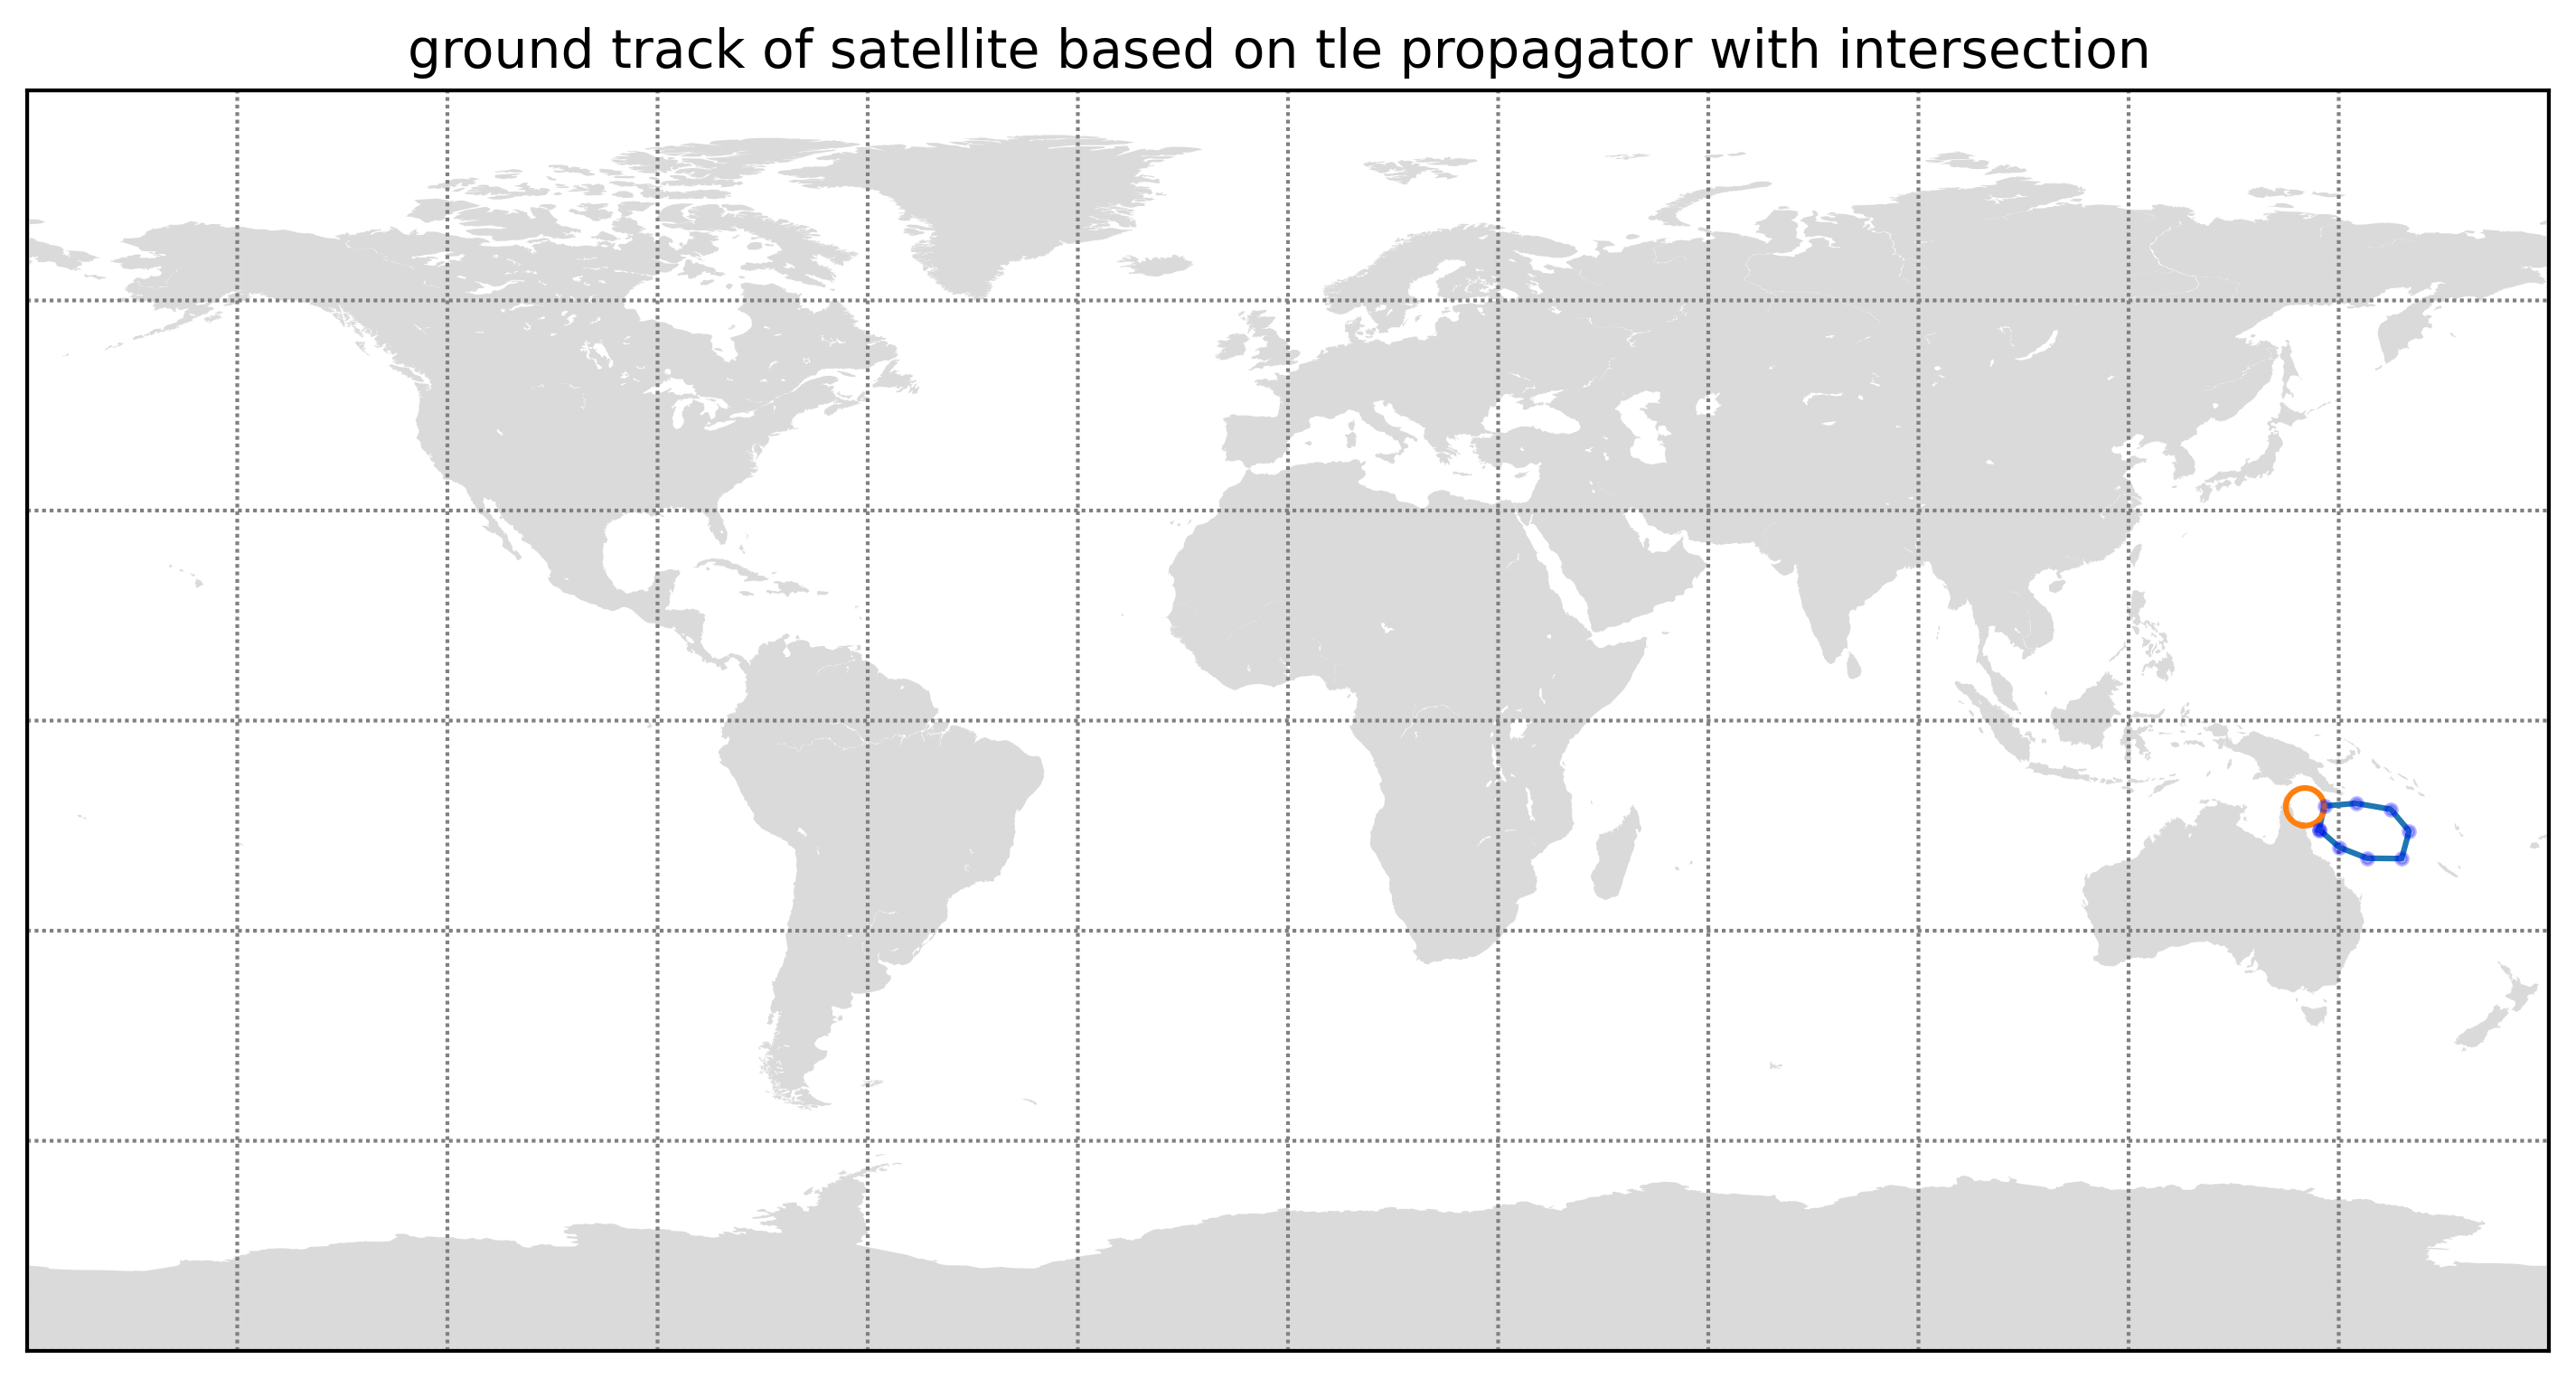

In [21]:
 # visualizing this intersection in map ploted

# 2024-06-02T11:57:47.145792Z
#  lets take the lat, long information from geojson map
# 2024-06-02T17:53:37.145792Z

"""
geod = Geod(ellps="WGS84")


testDate = AbsoluteDate(2024,6,2,19,22, 37.145792, TimeScalesFactory.getUTC())  #2024-06-02T18:14:07.145792Z

fplist, x,y = get_footprint(propagator_Upd_base2, testDate, earth)
listp = casting_footprintList(fplist)


# AreaOfInterest1 = [[66.801,67.521],[70.989,64.516],[91.7438,66.634],[88.929,70.937]]   # here first value is longitude and second is latitude
AreaOfInterest =[[
            147.17515827251634,
            -15.640078251023056
          ],
          [
            147.94567963567386,
            -12.187583366380892
          ],
          [
            152.47710504377255,
            -11.812564622640394
          ],
          [
            157.41096167261662,
            -12.652514202747142
          ],
          [
            160.04819327494533,
            -15.759696732458849
          ],
          [
            158.98519773901563,
            -19.70058922777251
          ],
          [
            154.059202587223,
            -19.649308459193833
          ],
          [
            150.1129330003555,
            -18.105241744613366
          ],
          [
            147.2062653984351,
            -15.552334895009977
          ]]

#this is random area near in russian territory for test
# plot this area on map for confirmation
lat_sat = [p[1]  for p in AreaOfInterest]
lon_sat = [p[0] for p in AreaOfInterest]


# plot the map and groundtrack of satellite using matplotlib

fig = plt.figure(figsize=(12, 8), dpi=300)

m = Basemap(projection='cyl',
            resolution='l',
            area_thresh=None)

m.drawmapboundary()     # fill_color='aqua')
m.fillcontinents(color='#dadada', lake_color='white')
m.drawmeridians(np.arange(-180, 180, 30), color='gray')
m.drawparallels(np.arange(-90, 90, 30), color='gray')
m.scatter(lon_sat, lat_sat, alpha=0.3, color='blue', zorder=3, marker='.')

polygon_area = Polygon(AreaOfInterest)
# polygon_area.is_valid()
polygonal_footprint = Polygon([[degrees(p.getLongitude()), degrees(p.getLatitude())] for p in listp])
# print(polygonal_footprint.is_valid())
polygonal_footprint = polygonal_footprint.buffer(0)
# Calculate the intersection (overlap) of the polygons
intersection = polygon_area.intersection(polygonal_footprint)
if (intersection.area>0.0):
    # Area of a geodesic polygon
    print(intersection.area)
    intser = str(intersection)
    read_intser_poly = wkt.loads(intser)
    area_sq_km = abs(geod.geometry_area_perimeter(read_intser_poly)[0]/1000000)
    print(f"area_sq_km: {area_sq_km}")

# Plot the polygons and their intersection
x1, y1 = polygon_area.exterior.xy
x2, y2 = polygonal_footprint.exterior.xy
xi, yi = intersection.exterior.xy

m.plot(x1, y1, label='Polygon area of interest')
m.plot(x2, y2, label='Polygon footprint')
plt.fill(xi, yi, alpha=0.5, label='Intersection')


plt.title("ground track of satellite based on tle propagator with intersection ", fontsize=14)
plt.show()



"""

"""
There is one issue, bug, fault with this method using polygon of footprint and earth surface area of interest in 2d,
that when satellite is at edge of 2d-plane of earth figure, circular shape of footrpit got elongagted, 
and in 2d earth shape figure it will seems like cylinder shape 
"""






In [102]:
"""
# To resolve this issue, lets calculate the area of polygon, simpy using python Shapely area method, and Geod.geometry_area_perimeter method
"""


"""
# import the pacakge Geod
from pyproj import Geod
from shapely import wkt

# lets take those two polygon
polygon1 = Polygon(AreaOfInterest)
polygon2_footprint = Polygon([[degrees(p.getLongitude()), degrees(p.getLatitude())] for p in listp])

# simply calculating the area
print(f"simple polygon area of area_of_interest: {polygon1.area} and footprint: {polygon2_footprint.area}")


# Specify a named ellipsoid
geod = Geod(ellps="WGS84")
geod_area_of_interest = abs(geod.geometry_area_perimeter(polygon1)[0])

geod_area_of_footprint = abs(geod.geometry_area_perimeter(polygon2_footprint)[0])


print(f"geod calculated_area of area of interest: {geod_area_of_interest/1000000} sq. km nd footprint: {geod_area_of_footprint/1000000} sq. km")


"""


simple polygon area of area_of_interest: 76.74469898874572 and footprint: 22.983996069082433
geod calculated_area of area of interest: 910240.0368983741 sq. km nd footprint: 276500.8957813492 sq. km


In [214]:
# dwell time and revisit time visualization and analysis

geojson file written success


In [45]:
"""
So the plan includes, for first

-define constellation

-define cumulative revisit time calculation

-then apply GA 

"""

epoch = AbsoluteDate(2024, 1, 1, 0, 0, 0.000, TimeScalesFactory.getUTC())

def create_walker_delta_constellation(num_planes, num_sats_per_plane, inclinations_deg):
    satellites = []     #for list of propagator
    mu = Constants.WGS84_EARTH_MU
    
    # inclination = radians(inclination_deg)

    for plane in range(num_planes):
        inclination =inclinations_deg[plane]    #degrees
        for sat in range(num_sats_per_plane):
            raan = degrees(2 * np.pi * plane / num_planes)   #degrees
            mean_anomaly = degrees(2 * np.pi * sat / num_sats_per_plane)    #degrees
            propagator = create_orbit_propagator(kepOrbEle.get("semi_major_axis"), 0.001, inclination,
                                         kepOrbEle.get("argument_of_perigee"),raan,
                                         mean_anomaly,
                                         epoch)
            satellites.append(propagator)
    
    return satellites      


def calculate_cumm_revisit_dwell_time(satellites, target_location, simulation_duration):
    # logger = EventsLogger()
    # cumulative_revisit_time = 0.0
    # propagator_Cons = []

    
    dwell_time_sats = []
    dwell_time_intervals = []
    revisit_time_sats = []
    
    for id, propagator in enumerate(satellites):
        
        calDT, dtInt = loopWholeFunction(propagator,epoch, simulation_duration, target_location, earth)
        
        dwell_time_sats.append((id,calDT))
        dwell_time_intervals.append((id,dtInt))
    
    # flatten the list of dwell time interval list data first
    desired_dtIntOfSat = [(index, value) for index, values in dwell_time_intervals for value in values]
    # calcualte revisit time, and cummulative revisit time
    revist_time_differences, cumm_revisit_time = calculate_revisit_time(desired_dtIntOfSat)
   
    
    # this will gives the cummulative dwell time
    total_sum = sum(sum(values) for _, values in dwell_time_sats)
    cummulative_dwell_time = timedelta(seconds = total_sum)
   
    return cumm_revisit_time,cummulative_dwell_time



# Define the evaluation function for the GA
def evaluate_revisit_time(individual):
    num_planes = len(individual)
    num_sats_per_plane = 4  # Example number of satellites per plane

    satellites = create_walker_delta_constellation(num_planes, num_sats_per_plane, individual)
    target_location = westernCentral_partArea
    simulation_duration = 86400.0  # 1 day in seconds

    codeblockTime= datetime.now()

    cumm_revisit_time, cumm_dwell_time = calculate_cumm_revisit_dwell_time(satellites, target_location, simulation_duration)

    print(f"total time it takes to cal cumm re time {(datetime.now() - codeblockTime)}")
    print("cummulative revisit time: ",cumm_revisit_time)
    return cumm_revisit_time,



def evaluate_dwell_time(individual):
    num_planes = len(individual)
    num_sats_per_plane = 4  # Example number of satellites per plane

    satellites = create_walker_delta_constellation(num_planes, num_sats_per_plane, individual)
    target_location = westernCentral_partArea
    simulation_duration = 86400.0  # 1 day in seconds

    codeblockTime= datetime.now()

    cumm_revisit_time, cumm_dwell_time = calculate_cumm_revisit_dwell_time(satellites, target_location, simulation_duration)

    print(f"total time it takes to cal cumm re time {(datetime.now() - codeblockTime)}")
    # print("cummulative revisit time: ",cumm_revisit_time)
    return cumm_dwell_time,



def evaluate_both(individual):

    num_planes = len(individual)
    num_sats_per_plane = 4  # Example number of satellites per plane

    satellites = create_walker_delta_constellation(num_planes, num_sats_per_plane, individual)
    target_location = westernCentral_partArea
    simulation_duration = 86400.0  # 1 day in seconds

    codeblockTime= datetime.now()

    cumm_revisit_time, cumm_dwell_time = calculate_cumm_revisit_dwell_time(satellites, target_location, simulation_duration)

    print(f"total time it takes to cal cumm re time {(datetime.now() - codeblockTime)}")
    # print("cummulative revisit time: ",cumm_revisit_time)
    return cumm_revisit_time, cumm_dwell_time


"""
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, 1.0))

This code produces a fitness that minimizes the first objective and maximize the second one.
  The weights can also be used to vary the importance of each objective one against another
"""








# Define the evaluation function for the GA
# def evaluate(individual):
#     num_planes = len(individual)
#     num_sats_per_plane = 4  # Example number of satellites per plane
#     altitude = 700e3  # Example altitude in meters
#     satellites = create_walker_delta_constellation(num_planes, num_sats_per_plane, individual)
#     target_location = westernCentral_partArea
#     simulation_duration = 86400.0  # 1 day in seconds

#     codeblockTime= datetime.now()
    
#     revisit_time = calculate_cumulative_revisit_time(satellites, target_location, simulation_duration)

#     print(f"total time it takes to cal cumm re time {(datetime.now() - codeblockTime)}")
#     print("cummulative revisit time: ",revisit_time)
#     return revisit_time,


'\ncreator.create("FitnessMulti", base.Fitness, weights=(-1.0, 1.0))\n\nThis code produces a fitness that minimizes the first objective and maximize the second one.\n  The weights can also be used to vary the importance of each objective one against another\n'

In [40]:
# # flatten the list of dwell time interval list data first
# dwell_time_intervals =[(0,
#   [['2024-06-02T19:27:57.145792', '2024-06-02T19:30:57.145792']])]
# print(len(dwell_time_intervals))
# desired_dtIntOfSat = [(index, value) for index, values in dwell_time_intervals for value in values if len(values)>1]
# # calcualte revisit time, and cummulative revisit time
# print(desired_dtIntOfSat)
# revist_time_differences, cumm_revisit_time = calculate_revisit_time(desired_dtIntOfSat)
# if cumm_revisit_time== timedelta(seconds =0):
#     cumm_revisit_time = timedelta(seconds = 869000)
#     print(cumm_revisit_time)

In [46]:
from deap import base, creator, tools, algorithms

# Create the fitness and individual classes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Attribute generator: Define inclination angle for each orbital plane in degrees
def random_inclination():
    return np.random.uniform(0, 180)
# Structure initializers: Each individual is a list of inclinations for each plane
NUM_PLANES = 3  # Example number of orbital planes




toolbox.register("individual", tools.initRepeat, creator.Individual, random_inclination, n=NUM_PLANES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate_revisit_time)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1.0, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run the Genetic Algorithm
population = toolbox.population(n=20)
algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=2, stats=None, halloffame=None, verbose=True)

# Extract and print the best solution
best_individual = tools.selBest(population, k=1)[0]
print(f"Best individual: {best_individual}")


/opt/anaconda3/envs/OrekitEnvironment/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/anaconda3/envs/OrekitEnvironment/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


total time it takes to cal cumm re time 0:00:14.471505
cummulative revisit time:  17:25:50
total time it takes to cal cumm re time 0:00:15.369621
cummulative revisit time:  14:59:40
total time it takes to cal cumm re time 0:00:15.043777
cummulative revisit time:  19:12:10
total time it takes to cal cumm re time 0:00:15.428640
cummulative revisit time:  22:19:00
total time it takes to cal cumm re time 0:00:15.597524
cummulative revisit time:  18:47:10
total time it takes to cal cumm re time 0:00:15.906133
cummulative revisit time:  18:53:30
total time it takes to cal cumm re time 0:00:15.267317
cummulative revisit time:  16:32:40
total time it takes to cal cumm re time 0:00:15.612125
cummulative revisit time:  19:24:20
total time it takes to cal cumm re time 0:00:15.973340
cummulative revisit time:  21:06:30
total time it takes to cal cumm re time 0:00:15.792455
cummulative revisit time:  21:54:20
total time it takes to cal cumm re time 0:00:16.084496
cummulative revisit time:  19:02:50

In [54]:
# Extract and print the best solution
best_individual = tools.selBest(population, k=5)[0]
print(f"Best individual: {best_individual}")


Best individual: [-21.800937414179113, 15.567105339053487, 3.887809055836737]


In [101]:
# Assuming you've already run the genetic algorithm
best_individual = tools.selBest(population, k=1)[0]
best_fitness = best_individual.fitness.values[0]

print(f"Best individual (inclinations): {best_individual}")
print(f"Best fitness (cumulative revisit time): {best_fitness}")



Best individual (inclinations): [161.62102225164074, 7.157347932422281, -3.8460454451172836]
Best fitness (cumulative revisit time): 6:41:50


In [104]:
# lets visualize the constellation with best inclination parameters
"""
Best individual (inclinations): [161.62102225164074, 7.157347932422281, -3.8460454451172836]
Best fitness (cumulative revisit time): 6:41:50
"""
satellites = create_walker_delta_constellation(3,4, [161.62102225164074, 7.157347932422281, -3.8460454451172836])

satellites_Positions = propagator_to_statePosition(satellites, 60.0)

czml_data = generate_czml(satellites_Positions)
    
    
# Save to CZML file
with open('satellites_Propagator_from_GA.czml', 'w') as f:
    json.dump(czml_data, f, indent=4)
    



In [32]:
# lets visualize the constellation with best inclination parameters

satellites = create_walker_delta_constellation(3,4, [33.76352116055069, 60.35361457358263, 41.977582569318706])

satellites_Positions = propagator_to_statePosition(satellites, 60.0)

czml_data = generate_czml(satellites_Positions)
    
    
# Save to CZML file
with open('satellites_Propagator_from_GA_1day.czml', 'w') as f:
    json.dump(czml_data, f, indent=4)
    



In [17]:
# # Earth model and target location (example: Paris)
# earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
#                          Constants.WGS84_EARTH_FLATTENING,
#                          FramesFactory.getITRF(True))




"""
# Set the initial date and duration for the propagation
initial_date = AbsoluteDate(2024, 6, 1, 0, 0, 0.0, TimeScalesFactory.getUTC())
final_date = initial_date.shiftedBy(86400.0)  # One day later
duration = 1.0*60.0*60.0    #seconds propagate for 24 hrs

def calculate_cumm_revisit_time(individual, num_planes, sats_per_plane):
    # Example: Assuming each plane has the same inclination
    inclination, raan_base, arg_per_base = individual[:3]
    # max_revisit_time = float('inf')
    propagator_Cons = []
    dwell_time_sats = []
    dwell_time_intervals = []
    revisit_time_sats = []

    for plane in range(num_planes):
        raan = raan_base + plane * (2 * np.pi / num_planes)  # Spread RAAN across planes
        for sat in range(sats_per_plane):
            # Calculate the orbital elements
            arg_perigee = arg_per_base + sat * (2 * np.pi / sats_per_plane)
            mean_anomaly = (2 * np.pi / sats_per_plane) * sat  # Spread satellites evenly

            # orbit = KeplerianOrbit(Constants.WGS84_EARTH_EQUATORIAL_RADIUS + 550000.0,
            #                        0.001,  # Small eccentricity for near-circular orbits
            #                        inclination,
            #                        arg_perigee, raan, mean_anomaly,
            #                        PositionAngleType.MEAN, FramesFactory.getEME2000(), initial_date,
            #                        Constants.WGS84_EARTH_MU)

            propagator = create_orbit_propagator(kepOrbEle.get("semi_major_axis"), 0.001, inclination,
                                         arg_perigee,raan,
                                         mean_anomaly,
                                         initial_date)
            propagator_Cons.append(propagator)



    satellites_Positions = propagator_to_statePosition(propagator_Cons, 60.0)

    czml_data = generate_czml(satellites_Positions)
    
    
    # Save to CZML file
    with open('satellites_Propagator_from_GA.czml', 'w') as f:
        json.dump(czml_data, f, indent=4)
    

    for id, propagator in enumerate(propagator_Cons):
        
        calDT, dtInt = loopWholeFunction(propagator,initial_date, duration, westernCentral_partArea, earth)
        
        dwell_time_sats.append((id,calDT))
        dwell_time_intervals.append((id,dtInt))
    
    # flatten the list of dwell time interval list data first
    desired_dtIntOfSat = [(index, value) for index, values in dtIntOf6Sat for value in values]
    # calcualte revisit time, and cummulative revisit time
    revist_time_differences, cumm_revisit_time = calculate_revisit_time(desired_dtIntOfSat)
   
    
    # this will gives the cummulative dwell time
    total_sum = sum(sum(values) for _, values in calDtOf6Sat)
    cummulative_dwell_time = timedelta(seconds = total_sum)

    return cumm_revisit_time



"""

In [16]:
# pip install deap 
"""
use of deap library for easy implimentation of GA
"""

"""

Okay, now the plan is 

our fitness function will be that which
calculate the revisit time (max and min, and cummulativie total revisit time and dwell time as well, where, 
first we take the reference value as number of planes and satellites, and create the propapagator list as constellation, with chaning inclination and raan and maybe mean anamoly(for satellite),
and later on from the listed values, we will calculate the values,

rest of random calculation and testing should be done by genetic algorithm, with best fitness

"""



'\n\nOkay, now the plan is \n\nour fitness function will be that which\ncalculate the revisit time (max and min, and cummulativie total revisit time and dwell time as well, where, \nfirst we take the reference value as number of planes and satellites, and create the propapagator list as constellation, with chaning inclination and raan and maybe mean anamoly(for satellite),\nand later on from the listed values, we will calculate the values,\n\nrest of random calculation and testing should be done by genetic algorithm, with best fitness\n\n'

In [ ]:
# Number of planes and satellites per plane


"""
num_planes = 3
sats_per_plane = 4

# GA setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 2 * np.pi)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", lambda ind: (calculate_cumm_revisit_time(ind, num_planes, sats_per_plane),))

# Initialize population
population = toolbox.population(n=50)

# Run GA
NGEN = 1
CXPB, MUTPB = 0.5, 0.2

for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = map(toolbox.evaluate, offspring)

    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    population = toolbox.select(offspring, k=len(population))

# Get the best individual
best_ind = tools.selBest(population, 1)[0]
print("Best individual is:", best_ind)
print("With a fitness (revisit time) of:", best_ind.fitness.values[0], "seconds")


"""


area of footprint simply calculated:  21.897803425060644
percentage of area covered by footprint on area of interset:  0.0
itersect Geodesic area: 0.000 m^2
2024-06-01T00:00:00.000Z
area of footprint simply calculated:  21.898299365886672
percentage of area covered by footprint on area of interset:  0.0
itersect Geodesic area: 0.000 m^2
2024-06-01T00:00:20.000Z
area of footprint simply calculated:  21.899135332105445
percentage of area covered by footprint on area of interset:  0.0
itersect Geodesic area: 0.000 m^2
2024-06-01T00:00:40.000Z
area of footprint simply calculated:  21.900310295783278
percentage of area covered by footprint on area of interset:  0.0
itersect Geodesic area: 0.000 m^2
2024-06-01T00:01:00.000Z
area of footprint simply calculated:  21.901822934890276
percentage of area covered by footprint on area of interset:  0.0
itersect Geodesic area: 0.000 m^2
2024-06-01T00:01:20.000Z
area of footprint simply calculated:  21.903671635119977
percentage of area covered by foo

/opt/anaconda3/envs/OrekitEnvironment/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/anaconda3/envs/OrekitEnvironment/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


area of footprint simply calculated:  22.401073473141917
percentage of area covered by footprint on area of interset:  0.0
itersect Geodesic area: 0.000 m^2
2024-06-01T01:58:00.000Z
area of footprint simply calculated:  22.412517255210318
percentage of area covered by footprint on area of interset:  0.0
itersect Geodesic area: 0.000 m^2
2024-06-01T01:58:20.000Z
area of footprint simply calculated:  22.423905122448303
percentage of area covered by footprint on area of interset:  0.0
itersect Geodesic area: 0.000 m^2
2024-06-01T01:58:40.000Z
area of footprint simply calculated:  22.435230703462132
percentage of area covered by footprint on area of interset:  0.0
itersect Geodesic area: 0.000 m^2
2024-06-01T01:59:00.000Z
area of footprint simply calculated:  22.446487805478885
percentage of area covered by footprint on area of interset:  0.0
itersect Geodesic area: 0.000 m^2
2024-06-01T01:59:20.000Z
area of footprint simply calculated:  22.457670419395615
percentage of area covered by foo

In [21]:
# Get the best individual
best_ind = tools.selBest(population, 1)[0]
print("Best individual is:", best_ind)
print("With a fitness (revisit time) of:", best_ind.fitness.values[0], "seconds")


Best individual is: [0.8322155474800195, 1.60249768204139, 6.6765244978446]
With a fitness (revisit time) of: 23:56:50 seconds


In [22]:
tools.selBest(population,3)[0]

[0.8322155474800195, 1.60249768204139, 6.6765244978446]

In [26]:
"""

import random
from deap import creator, base, tools, algorithms

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=100)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    return sum(individual),

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=300)

NGEN=40
for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.1)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))


"""



In [34]:
top10 = tools.selBest(population, k=10)

288.0